In [11]:
import torch 
import torch.nn as nn 

import h5py, os
import numpy as np
from matplotlib import pyplot as plt
import data_loader
from functions import transforms as T

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available


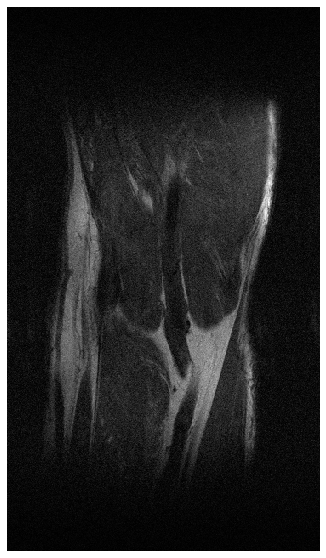

In [31]:
#PREPARE THE DATA 
data_list = data_loader.load_data_path('/data/local/NC2019MRI/train', '/data/local/NC2019MRI/train')
# slices, height, width = input_k.shape()

acc = 8
cen_fract = 0.04
seed = False # random masks for each slice 
num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
# create data loader for training set. It applies same to validation set as well
train_dataset = data_loader.MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
train_loader = data_loader.DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers)

for iteration, sample in enumerate(train_loader):
    
    img_gt, img_und, rawdata_und, masks, norm = sample
    D = T.complex_abs(img_gt).squeeze()
    
    # from left to right: mask, masked kspace, undersampled image, ground truth
    data_loader.show_slices([D], [0], cmap='gray')
    if iteration < 1: break
#make x_train_tensor and y_train_tensor

#from torch.utils.data import TensorDataset, DataLoader

#train_data = TensorDataset(x_train_tensor, y_train_tensor)
#train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)


In [ ]:
#build the network

#fully connected input layer (64)

#--

#convolutional layers (relu)

#fully connected output layer (64)


In [ ]:
class ConvolutionalBlock(nn.Module):
    """
    2 lots of:
        3x3 convolutional blocks
        Instance Normalisation 
        ReLu
        Dropout 
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)



In [ ]:
class NeuralNetworkModel(nn.Module):
    """
        Unet model
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()
        

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.layers_list_downsample = nn.ModuleList()
        convblock_1 = ConvolutionalBlock(in_chans, chans, drop_prob)
        layers_list += convblock_1
        
        ch = chans
        #create a new convolutionalm block for each layer, doubling the number of channels to downsample 
        for i in range(num_pool_layers - 1):
            new_convBlock = ConvolutionBlock(ch, ch * 2, drop_prob)
            self.layers_list_downsample += [new_convBlock]
            ch *= 2
        #one for convolution block with the same number of channels as the previous    
        self.conv = ConvolutionBlock(ch, ch, drop_prob)

        #the same thing but decreasing the chanells to upsample 
        self.layers_list_upsample = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            new_convBlock = ConvolutionBlock(ch * 2, ch // 2, drop_prob)
            self.layers_list_upsample += [new_convBlock]
            ch //= 2
        self.layer_list_upsample += [ConvBlock(ch * 2, ch, drop_prob)]
        
        #2 convolution layers to build the data up to the same size at the input 
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.layer_list_downsample:
            output = layer(output)
            stack.append(output)
            #apply 2x2 max pooling 
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.layer_list_downsample:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [ ]:
import torch.optim as optim
torch.manual_seed(42)

#create a model
model = NeuralNetworkModel().to(device)

#inspect parameters 
print("Before training: \n", model.state_dict())

In [ ]:
#loss function
#start point: L1 loss |output - gold standard|

#ssim loss

#VGG loss

#GAN loss 

#L2 mean squared error between the output and the gold standard 

#mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
#optimiser
#stochastic gradient descent (SGD)
optimiser = optim.SGD(model.parameters(), lr=lr)

In [ ]:
"""The proposed method consists of two major components : deep learning using U-net and k-space correction. 
As a preprecessing, we first fill in zeros for the unmeasured region of the undersampled data to get the 
zero-padded data. Then, we take the inverse Fourier transform, take its absolute value, and obtain the folded image.
After the preprocess, we put this folded image into the trained U-net and produce the U-net output. 
The U-net recovers the zero-padded part of the k-space data. 
We take the Fourier transform and replace the unpadded parts by the original k-space data to preserve the 
original measured data. Finally, we obtain the final output image by applying the inverse Fourier 
transform and absolute value."""

In [ ]:
#preprocessing:
#zero pad the masked data 

#take the inverse Fourier transform 

In [ ]:
#train the network 
# set learning rate
lr = 1e-1

# set number of epoches, i.e., number of times we iterate through the training set
epoches = 100

for epoch in range(epoches):
    model.train()             # set the model to training mode 
    for x_batch, y_batch in train_loader:
        # send tensors to device (cpu/cuda)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimiser.zero_grad() #avoid accumulating gradients
        y_pred = new_model(x_batch)
        loss = loss_fn(y_batch, y_pred)
        loss.backward() # calculate gradients
        optimiser.step() # update model's params
         

print("After training: \n", model.state_dict())NN = Neural_Network()
